<a href="https://colab.research.google.com/github/Jang-Boa/Deep_Learning/blob/main/Lung_Image_segment_11_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [ ]:
!wget https://github.com/younggon2/Education-ComputerVision-DeepLearning/raw/master/res/Lung_Segmentation.zip

In [ ]:
!unzip Lung_Segmentation.zip

# Read image

In [166]:
### >>> Code <<< ###
import os 

# image_shape = (image_height, image_width, image_channel)
image_height = 256
image_width = 256
image_channel = 3

# image_size = (256,256)
num_classes = 3 # right and left and background
# batch_size = 32

image_dir = 'image'
label_dir = 'label'

image_file = os.listdir(image_dir)
label_file = os.listdir(label_dir)

img_head = []
for i in image_file:
  name = os.path.splitext(i)[0]
  file_type = os.path.splitext(i)[1]
  img_head.append(name)

image_path = []
label_path = []
for fh in img_head:
  image_path.append(os.path.join(image_dir,fh+file_type))
  label_path.append(os.path.join(label_dir,fh+file_type))

# image_path = [os.path.join(image_dir,fname) for fname in os.listdir(image_dir)] -> 순서를 정렬할 이유가 없다.. 섞어줘야 하기 때문에 random sampling 
# label_path = [os.path.join(label_dir, fname) for fname in os.listdir(label_dir)]
img_num = len(img_head)
print(f'총 이미지의 갯수: {img_num}, 이미지 확장자: {file_type}')

총 이미지의 갯수: 566, 이미지 확장자: .png


In [167]:
image_file[1]

'resize_CHNCXR_0034_0.png'

# Check Image

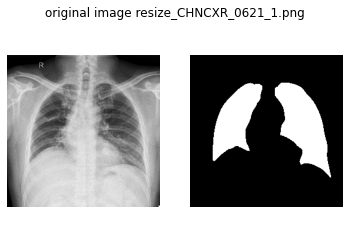

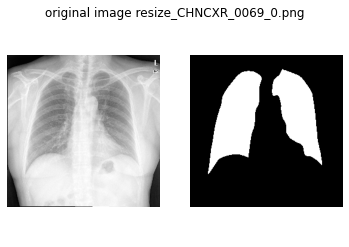

In [168]:
### >>> Code <<< ###
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Seed 고정
seed = 42
random.seed(seed)

for i in random.sample(range(img_num),2):

  fig = plt.figure()
  plt.title(f'original image {image_file[i]}')
  plt.axis('off')

  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(load_img(image_path[i]))
  # ax1.set_title(f'original image {image_file[1]}')
  ax1.axis('off')

  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(load_img(label_path[i]))
  # ax2.set_title(f'label image {label_file[1]}')
  ax2.axis('off')

  plt.show()

# 이미지 세분화 

In [169]:
### >>> Code <<< ###
from scipy import ndimage as ndi
import collections

def region_based_segmentation(path):
  """ 
  영역을 기반으로 라벨을 나누어 준다. 
  """

  img = load_img(path, target_size=(image_height, image_width),color_mode='grayscale') 
  img = img_to_array(img) # image -> array(256,256,1)

  labels, nlabels = ndi.label(img) # labels => (256,256,1), nlabels = number of labels

  return labels, nlabels

##
def left_and_right(labels, top):
  """
  이미지의 왼쪽과 오른쪽으로 구분
  left => 1, right -> 2
  """
  left = 1
  right = 2

  a = np.where(labels==top[1]) # -> 배경을 제외하고 top 중 라벨이 많은 것
  b = np.where(labels==top[2]) # -> 라벨이 적은 것

  x1 = a[0]
  y1 = a[1]
  z1 = a[2]
  x2 = b[0]
  y2 = b[1]
  z2 = b[2]

  if y1[0] < y2[0]: # a-> left, b-> right
    for m in range(len(x1)):
      labels[x1[m], y1[m], z1[m]] = left
    for n in range(len(x2)):
      labels[x2[n], y2[n], z2[n]] = right

  else: # a-> rigjt, b->left
    for m in range(len(x1)):
      labels[x1[m], y1[m], z1[m]] = right
    for n in range(len(x2)):
      labels[x2[n], y2[n], z2[n]] = left

  return labels

##
def segment_label(path):
  """
  이미지 세분화 작업 후 이미지 처리 과정 -> 라벨 정리
  """
  labels, nlabels = region_based_segmentation(path)

  unique, counts = np.unique(labels,return_counts=True) # ndarray 에 존재하는 요소의 값과 갯수를 리스트로 반환

  # count로 많은 순서대로 정렬 및 그에 해당하는 라벨을 리턴
  idx_order = np.argsort(-counts) # 갯수가 많은 순으로 라벨을 정리
  num_order = np.sort(counts)[::-1] # 갯수가 많은 순으로 갯수를 정리

  top = idx_order[:3] # top 3 개의 라벨만 골라서 리스트에 정리

  # label은 background, right, left 로 3[0-2]개가 생성되야 한다. 
  if nlabels > 2: # label의 갯수가 많은 경우
    lst = [unique[idx] for idx in range(len(counts)) if counts[idx] < 20] # 라벨의 갯수가 20보다 작은 라벨들 
    
    for x in range(256):
      for y in range(256):
        if labels[x,y,0] in lst:
          labels[x,y,0] = 0 # 갯수가 20보다 적은 라벨은 배경으로 치환
        elif (labels[x,y,0] not in top) and (labels[x,y,0] not in lst):
          labels[x,y,0] = top[-1] # 계산 필요... -> 20 보다 큰 값의 라벨은 어디에 속할지 정해주어야 한다.
    
  labels = left_and_right(labels,top)

  return labels

In [170]:
### >>> Code <<< ###
# data 정리
import cv2
X = np.zeros((img_num,image_height,image_width,1),dtype='float32')
y = np.zeros((img_num,image_height,image_width,1),dtype='float32')

for j, path in enumerate(img_head):
  image = np.array(load_img(os.path.join(image_dir,path+file_type)))
  image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  image = image[:,:,np.newaxis]
  image = image /255.
  X[j] = image

  label = segment_label(os.path.join(label_dir,path+file_type)) # segment function
  y[j] = label

In [171]:
X.shape, y.shape

((566, 256, 256, 1), (566, 256, 256, 1))

## onehot

In [172]:
from keras.utils.np_utils import to_categorical
one_hot_y = np.zeros((len(y), image_height, image_width, image_channel))
for i in range(len(y)):
  one_hot = to_categorical(y[i])
  one_hot_y[i] = one_hot
one_hot_y.shape

(566, 256, 256, 3)

### 이미지 라벨링 확인 

In [173]:
# # 모든 라벨 이미지 확인 작업 진행
# os.mkdir('./result') # create result folder 
# for i in range(len(y)):
#   img = y[i]*0.5*255
#   img = img.astype('uint8')
#   io.imsave(f'./result/{img_head[i]}.png',img)

In [174]:
# # 폴더가 비어있지 않아도 강제 디렉토리 삭제
# import shutil
# shutil.rmtree('./result')

In [175]:
# !zip -r result.zip ./result

In [176]:
# # to check image is seperated well into right and left
# count = 0
# for j in range(img_num): 
#   arr = y[j].flatten()
#   a = 0
#   b = 0
#   c = 0
#   d = 0
#   for i in arr:
#     if i == 0:
#       a += 1
#     elif i == 1:
#       b += 1
#     elif i == 2:
#       c += 1
#     else:
#       d += 1 
#   if d != 0:
#     print(j)
#     count += 1

# # print(a,b,c,d)
# # print(a+b+c+d)
# # print(len(arr), arr.size)
# print(count)

# Split DataSet

In [177]:
# Shuffle
import random
tmp = [[X,y] for X, y in zip(X, one_hot_y)]
random.shuffle(tmp)
X_ = np.array([n[0] for n in tmp])
y_ = np.array([n[1] for n in tmp])

In [178]:
X_.shape, y_.shape

((566, 256, 256, 1), (566, 256, 256, 3))

In [179]:
from sklearn.model_selection import train_test_split

test_size = 0.2
X_train, X_test, y_train, y_test  = train_test_split(X_, y_, test_size=test_size, random_state=seed)
X_train, X_val, y_train,y_val = train_test_split(X_train, y_train, test_size=test_size, random_state=seed)

print(f"""train num: {len(X_train)}
validation num: {len(X_val)}
test num: {len(X_test)}""")

train num: 361
validation num: 91
test num: 114


In [180]:
X_train.shape, y_train.shape

((361, 256, 256, 1), (361, 256, 256, 3))

# Check Image

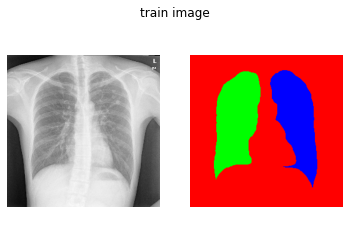

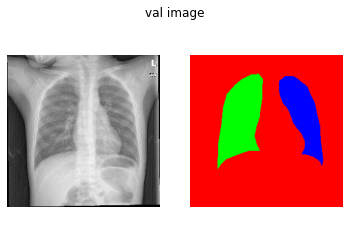

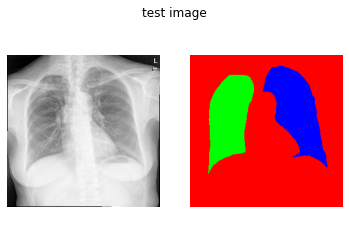

In [181]:
from tensorflow.keras.preprocessing.image import array_to_img
i = random.randint(0,3)

fig1 = plt.figure()
plt.title('train image')
plt.axis('off')
fig2 = plt.figure()
plt.title('val image')
plt.axis('off')
fig3 = plt.figure()
plt.title('test image')
plt.axis('off')

# train image
ax1 = fig1.add_subplot(1,2,1)
ax1.imshow(array_to_img(X_train[i]),'gray')
ax1.axis('off')

ax2 = fig1.add_subplot(1,2,2)
ax2.imshow(array_to_img(y_train[i]),'gray')
ax2.axis('off')

# val image
ax3 = fig2.add_subplot(1,2,1)
ax3.imshow(array_to_img(X_val[i]),'gray')
ax3.axis('off')

ax4 = fig2.add_subplot(1,2,2)
ax4.imshow(array_to_img(y_val[i]),'gray')
ax4.axis('off')

# test image
ax5 = fig3.add_subplot(1,2,1)
ax5.imshow(array_to_img(X_test[i]),'gray')
ax5.axis('off')

ax6 = fig3.add_subplot(1,2,2)
ax6.imshow(array_to_img(y_test[i]),'gray')
ax6.axis('off')

plt.show()

# Create Model

In [182]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, Conv2DTranspose
from keras import Model

def unet(image_height, image_width, num_classes):
    # inputs = Input(input_size)
    inputs = Input(shape=(image_height, image_width, 1),name='U-net')
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = Concatenate()([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Concatenate()([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Concatenate()([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Concatenate()([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)
    # output-> 다수의 클래스를 분류해야 하기 때문에 softmax 활성함수를 사용합니다. 

    return Model(inputs=[inputs], outputs=[outputs])

In [183]:

unet_model = unet(image_height, image_width, num_classes)
# import tensorflow as tf
# tf.random.set_seed(0)
# unet_model_2 = tf.keras.models.clone_model(unet_model)
# unet_model.summary()

# Train Model

In [184]:
from tensorflow.keras import backend as K
def dice_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)

def dice_coef_loss(y_true, y_pred):
  return 1 - dice_coef(y_true, y_pred)

In [185]:
# import tensorflow as tf
# def dice_coef(y_true,y_pred):
#   numerator = 2. * tf.reduce_sum(y_true*y_pred) + 1
#   denominator = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1
#   return numerator/denominator
# def dice_coef_loss(y_true, y_pred):
#   return 1 - dice_score(y_true, y_pred)

In [187]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(learning_rate=0.0001)
unet_model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=[dice_coef])

In [188]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

epochs = 300 
batch_size = 32

filename = 'checkpoint-epoch-{}-batch-{}-trial-001.h5'.format(epochs, batch_size)
checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다                             
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다 
                             verbose=1,            # 로그를 출력합니다           
                             save_best_only=True,  # 가장 best 값만 저장합니다  
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max 
                             )

earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=15,         # 15회 Epoch동안 개선되지 않는다면 종료
                             )

In [189]:
hist = unet_model.fit(X_train,y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_val,y_val), callbacks=[checkpoint,earlystopping])

# save_weights
unet_model.save_weights('Unet_weight_save.h5')
keras.models.save_model(unet_model,'Unet_Model_save.h5')

Epoch 1/300
12/12 [==============================] - 5s 316ms/step - loss: 1.0938 - dice_coef: 0.3358 - val_loss: 1.0506 - val_dice_coef: 0.3503

Epoch 00001: val_loss improved from inf to 1.05055, saving model to checkpoint-epoch-300-batch-32-trial-001.h5
Epoch 2/300
12/12 [==============================] - 3s 281ms/step - loss: 0.9878 - dice_coef: 0.3841 - val_loss: 0.8206 - val_dice_coef: 0.5367

Epoch 00002: val_loss improved from 1.05055 to 0.82055, saving model to checkpoint-epoch-300-batch-32-trial-001.h5
Epoch 3/300
12/12 [==============================] - 3s 283ms/step - loss: 0.8145 - dice_coef: 0.5339 - val_loss: 0.7730 - val_dice_coef: 0.5541

Epoch 00003: val_loss improved from 0.82055 to 0.77304, saving model to checkpoint-epoch-300-batch-32-trial-001.h5
Epoch 4/300
12/12 [==============================] - 3s 282ms/step - loss: 0.7690 - dice_coef: 0.5652 - val_loss: 0.7492 - val_dice_coef: 0.5762

Epoch 00004: val_loss improved from 0.77304 to 0.74918, saving model to che

# 학습 결과

In [190]:
print(hist.history.keys())

dict_keys(['loss', 'dice_coef', 'val_loss', 'val_dice_coef'])


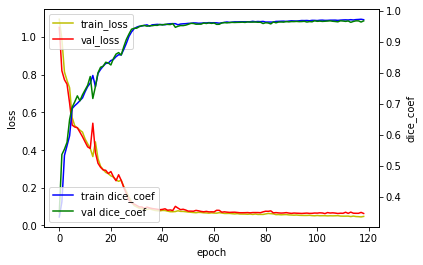

In [191]:
# 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'],'y',label='train_loss')
loss_ax.plot(hist.history['val_loss'],'r',label='val_loss')

acc_ax.plot(hist.history['dice_coef'],'b',label='train dice_coef')
acc_ax.plot(hist.history['val_dice_coef'],'g',label='val dice_coef')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('dice_coef')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [192]:
# 모델 평가
score = unet_model.evaluate(X_test,y_test) #, verbose=1
print('dice_coef = ', score[1],'loss=', score[0])

4/4 [==============================] - 0s 82ms/step - loss: 0.0656 - dice_coef: 0.9666
dice_coef =  0.9665566086769104 loss= 0.06558294594287872


# Predict Result

In [ ]:
# from keras.models import load_model
# epochs = 150
# batch_size = 32
# filename = 'checkpoint-epoch-{}-batch-{}-trial-001.h5'.format(epochs, batch_size)
# unet_model.load_weights(filename)

In [193]:
# test image
import matplotlib.pyplot as plt
import numpy as np

def plotPredictions(X_train_,y_train_,X_val_,y_val_,X_test_,y_test_,model_):
  model = model_
  ### Train Image
  ix = np.random.randint(0,len(X_train_))
  image_ = X_train_[ix]
  label_ = y_train_[ix]
  input_ = np.expand_dims(image_,axis=0)
  mask_ = np.expand_dims(label_,axis=0)
  preds_train = model.predict(input_)
  preds_train_t = (np.argmax(preds_train, axis=-1)).reshape(256,256,1)
  ret = model.evaluate(input_, mask_)

  plt.subplot(1,3,1)
  plt.title(f'{ix} X_train')
  plt.axis('off')
  plt.imshow(array_to_img(image_),'gray')
  plt.subplot(1,3,2)
  plt.title('y_train')
  plt.axis('off')
  plt.imshow(label_,'gray')
  plt.subplot(1,3,3)
  plt.title('Prediction: %.4f'%(ret[1]))
  plt.axis('off')
  plt.imshow(array_to_img(preds_train_t),'gray')
  plt.show()

  ### Validation Image
  ix = np.random.randint(0,len(X_val_))
  image_ = X_val_[ix]
  label_ = y_val_[ix]
  input_ = np.expand_dims(image_,axis=0)
  mask_ = np.expand_dims(label_,axis=0)
  preds_val = model.predict(input_)
  preds_val_t = (np.argmax(preds_val, axis=-1)).reshape(256,256,1)
  ret = model.evaluate(input_, mask_)

  plt.subplot(1,3,1)
  plt.title(f'{ix} X_val')
  plt.axis('off')
  plt.imshow(array_to_img(image_),'gray')
  plt.subplot(1,3,2)
  plt.title('y_val')
  plt.axis('off')
  plt.imshow(label_,'gray')
  plt.subplot(1,3,3)
  plt.title('Prediction: %.4f'%(ret[1]))
  plt.axis('off')
  plt.imshow(array_to_img(preds_val_t),'gray')
  plt.show()
  
  ### Test Image
  ix = np.random.randint(0,len(X_test_))
  image_ = X_test_[ix]
  label_ = y_test_[ix]
  input_ = np.expand_dims(image_,axis=0)
  mask_ = np.expand_dims(label_,axis=0)
  preds_test = model.predict(input_)
  preds_test_t = (np.argmax(preds_test, axis=-1)).reshape(256,256,1)
  ret = model.evaluate(input_, mask_)

  plt.subplot(1,3,1)
  plt.title(f'{ix} X_test')
  plt.axis('off')
  plt.imshow(array_to_img(image_),'gray')
  plt.subplot(1,3,2)
  plt.title('y_test')
  plt.axis('off')
  plt.imshow(label_,'gray')
  plt.subplot(1,3,3)
  plt.title('Prediction: %.4f'%(ret[1]))
  plt.axis('off')
  plt.imshow(array_to_img(preds_test_t),'gray')
  plt.show()

1/1 [==============================] - 0s 19ms/step - loss: 0.0295 - dice_coef: 0.9801


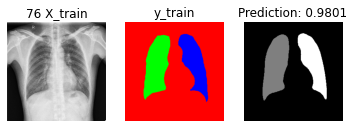

1/1 [==============================] - 0s 20ms/step - loss: 0.0400 - dice_coef: 0.9746


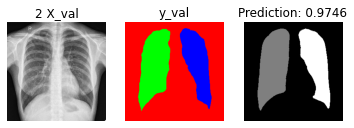

1/1 [==============================] - 0s 18ms/step - loss: 0.0717 - dice_coef: 0.9609


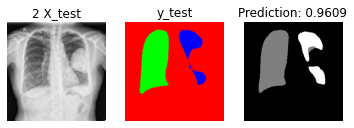

In [194]:
plotPredictions(X_train,y_train,X_val,y_val,X_test,y_test,unet_model)

# 노이즈 제거 필터 함수


In [237]:
def PredictImage(X_test_,y_test_,model_):
  model = model_

  ### Test Image
  ix = np.random.randint(0,len(X_test_))
  image_ = X_test_[ix]
  label_ = y_test_[ix]
  input_ = np.expand_dims(image_,axis=0)
  mask_ = np.expand_dims(label_,axis=0)
  y_pred_ = model.predict(input_)
  y_pred_t = (np.argmax(y_pred_, axis=-1)).reshape(256,256,1)
  ret = model.evaluate(input_, mask_)

  # plt.subplot(1,3,1)
  # plt.title(f'{ix} X_test')
  # plt.axis('off')
  # plt.imshow(array_to_img(image_),'gray')
  # plt.subplot(1,3,2)
  # plt.title('y_test')
  # plt.axis('off')
  # plt.imshow(label_,'gray')
  # plt.subplot(1,3,3)
  # plt.title('Prediction: %.4f'%(ret[1]))
  # plt.axis('off')
  # plt.imshow(array_to_img(y_pred_t),'gray')
  # plt.show()
  
  return input_, mask_, y_pred_

In [240]:
def remove(y_pred):
  y_ = tf.cast(y_pred, tf.double).numpy()
  a = np.argmax(y_,axis=-1)
  a = np.squeeze(a)
  a = a[:,:,np.newaxis]
  lst = np.where(a == 2)
  x = lst[0]
  y = lst[1]
  z = lst[2]
  for i in range(len(x)):
    a[x[i],y[i],z[i]] = 1
  l, n = ndi.label(a)
  u, c = np.unique(l, return_counts=True)
  idx = np.argsort(-c)
  num = np.sort(c)[::-1]
  t = idx[:3]
  if n > 2:
    for a in range(256):
      for b in range(256):
        if l[a,b,0] not in t:
          l[a,b,0] = 0

  l = left_and_right(l,t)

  h = np.zeros((256, 256, 3))
  h = to_categorical(l)

  p = y_[0]
  for i in range(0,256):
    for j in range(0,256):
      if np.argmax(p[i][j]) != np.argmax(h[i][j]):
        true_max_idx = np.argmax(h[i][j])
        false_max_idx = np.argmax(p[i][j])
        true_max_value = p[i][j][true_max_idx]
        p[i][j][true_max_idx] = p[i][j][false_max_idx] 
        p[i][j][false_max_idx] = true_max_value

  return p


In [254]:
# 40, 113.  
#14

In [263]:
input, mask, y_pred = PredictImage(X_test,y_test,unet_model)
y_ = tf.cast(y_pred, tf.double).numpy()
predict_dice_score = dice_coef(mask,y_).numpy()

1/1 [==============================] - 0s 19ms/step - loss: 0.0356 - dice_coef: 0.9739


In [264]:
p = remove(y_pred)
y_removed_noise = np.expand_dims(p,axis=0)

remove_noise_dice_score = dice_coef(mask,y_removed_noise).numpy()

1/1 [==============================] - 0s 20ms/step - loss: 0.0678 - dice_coef: 0.9613


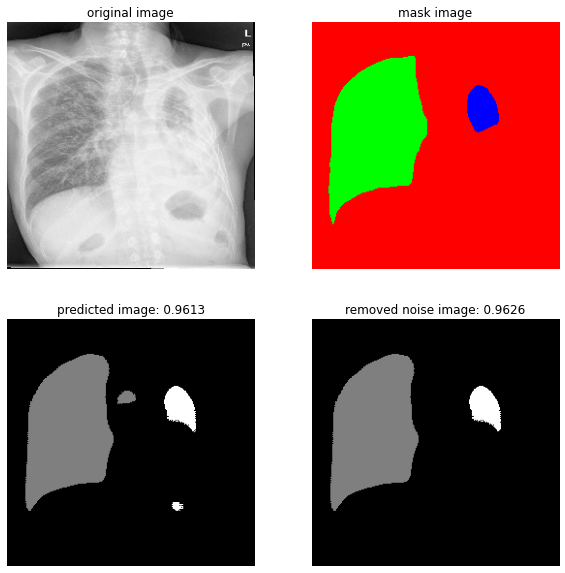

In [307]:

input, mask, y_pred = PredictImage(X_test,y_test,unet_model)
y_ = tf.cast(y_pred, tf.double).numpy()
predict_dice_score = dice_coef(mask,y_).numpy()

p = remove(y_pred)
y_removed_noise = np.expand_dims(p,axis=0)
remove_noise_dice_score = dice_coef(mask,y_removed_noise).numpy()



before_image = (np.argmax(y_pred, axis=-1)).reshape(256,256,1)
after_image = (np.argmax(p, axis=-1)).reshape(256,256,1)

plt.figure(figsize=(10,10))
if remove_noise_dice_score > predict_dice_score:
  plt.subplot(2,2,1)
  plt.title('original image')
  plt.imshow(array_to_img(input[0]),'gray')
  plt.axis('off') 
  plt.subplot(2,2,2)
  plt.title('mask image')
  plt.imshow(array_to_img(mask[0]))
  plt.axis('off') 
  plt.subplot(2,2,3)
  plt.title('predicted image: %0.4f'%predict_dice_score)
  plt.imshow(array_to_img(before_image),'gray')
  plt.axis('off') 
  plt.subplot(2,2,4)
  plt.title('removed noise image: %0.4f'%remove_noise_dice_score)
  plt.imshow(array_to_img(after_image),'gray')
  plt.axis('off') 
  plt.show
else:
  plt.subplot(1,3,1)
  plt.title('original image')
  plt.imshow(array_to_img(input[0]),'gray')
  plt.axis('off')
  plt.subplot(1,3,2)
  plt.title('mask image')
  plt.imshow(array_to_img(mask[0]))
  plt.axis('off')
  plt.subplot(1,3,3)
  plt.title('predicted image: %0.4f'%predict_dice_score)
  plt.imshow(array_to_img(before_image),'gray')
  plt.axis('off')
  plt.show
  

---

In [35]:
def average_filter(img):
  # Average Filter
  img_avg = img.copy()

  k_size = 10 # size of kernel 
  average = cv2.blur(img_avg, (k_size,k_size))
  # plt.imshow(average)
  y_avg_filter = np.expand_dims(average, axis=0)
  y_avg_filter = tf.cast(y_avg_filter, tf.double)

  return average, dice_coef(y_true, y_avg_filter).numpy()

In [36]:
def gaussian_fileter(img):
  # Gaussian Filter
  img_gaussian = img.copy()
  img_gaussian = np.clip((img + np.random.normal(scale = 0.1,size = img.shape)) * 255, 0, 255).astype('uint8') # white noise
  k_size = 11 # size of kernel 
  gaussian = cv2.GaussianBlur(img_gaussian, (k_size,k_size), 0)
  # plt.imshow(gaussian)
  gaussian_v = gaussian/255.
  y_gaussian_filter = np.expand_dims(gaussian_v,axis=0)
  y_gaussian_filter = tf.cast(y_gaussian_filter, tf.double)

  return gaussian_v, dice_coef(y_true,y_gaussian_filter).numpy()

In [37]:
def median_filter(img):
  # Median Filter
  img_median = img.copy()
  # # salt and pepper noise
  # np.random.seed(0)
  # N = 10000
  # idx1 = np.random.randint(img_median.shape[0],size = N)
  # idx2 = np.random.randint(img_median.shape[1],size = N)
  # img_median[idx1, idx2] = 0
  
  k_size = 3 # size of kernel 
  # img_median = img_median.astype('uint8')
  median = cv2.medianBlur(img_median, k_size)
  # plt.imshow(median)
  y_median_filter = np.expand_dims(median,axis=0)
  y_median_filter = tf.cast(y_median_filter,tf.double)
  return median, dice_coef(y_true,y_median_filter).numpy()

In [38]:
def bilateral_filter(img):
  # Bilateral filter
  img_bilateral = img.copy()
  img_bilateral = np.clip((img + np.random.normal(scale = 0.1,size = img.shape)) * 255, 0, 255).astype('uint8') # white noise

  k_size = 17 # size of kernel 
  bilateral = cv2.bilateralFilter(img_bilateral, k_size, 75,75)
  # plt.imshow(bilateral)
  bilateral_v = bilateral/255.
  y_bilateral_filter = np.expand_dims(bilateral_v,axis=0)
  y_bilateral_filter = tf.cast(y_bilateral_filter, tf.double)
  return bilateral_v,dice_coef(y_true, y_bilateral_filter).numpy()

# 후처리


In [49]:
import tensorflow as tf

def remove_noise(mask_, predict_):
  true = mask_[0]
  pred = predict_[0]
  
  for i in range(0,256):
    for j in range(0,256):
      if np.argmax(pred[i][j]) != np.argmax(true[i][j]):
        true_max_idx = np.argmax(true[i][j])
        false_max_idx = np.argmax(pred[i][j])
        true_max_value = pred[i][j][true_max_idx]
        pred[i][j][true_max_idx] = pred[i][j][false_max_idx] 
        pred[i][j][false_max_idx] = true_max_value

  img = np.argmax(pred,axis=-1)
  plt.imshow(img,'gray')
  pred = np.expand_dims(pred,axis=0)
  pred = tf.cast(pred,tf.double).numpy()
  return dice_coef(mask_, pred).numpy()

In [50]:
def filtering(mask_, predict_):
  y_true = mask_ # (1,256,256,3)
  y_pred = tf.cast(predict_, tf.double).numpy() # double tensor -> 64bit

  dic = {}
  pred_dic = {}
  origin_dice_score = dice_coef(y_true, y_pred).numpy()
  dic['y_original_pred'] = origin_dice_score
  pred_dic['y_original_pred'] = y_pred
  
  img = predict_[0] # shape (1,256,256,3) -> (256,256,1)
  # Average Filter
  avg_pred, avg_dice_score = average_filter(img)
  dic['y_avg_filter'] = avg_dice_score
  pred_dic['y_avg_filter'] = avg_pred

  # Gaussian Filter 
  gaussian_pred, gaussian_dice_score = gaussian_fileter(img)
  dic['y_gaussain_filter'] = gaussian_dice_score
  pred_dic['y_gaussain_filter'] = gaussian_pred

  # Median Filter
  median_pred, median_dice_score = median_filter(img)
  dic['y_median_filter'] = median_dice_score
  pred_dic['y_median_filter'] = median_pred

  # Bilateral filter
  bilateral_pred, bilateral_dice_score = bilateral_filter(img)
  dic['y_bilateral_filter'] = bilateral_dice_score
  pred_dic['y_bilateral_filter'] = bilateral_pred

  name_max_dice_score = max(dic.keys(),key=(lambda x: dic[x]))
  max_dice_score = dic[name_max_dice_score]
  # pred = pred_dic[name_max_dice_score]
  # final_score = remove_noise(y_true,pred)
  
  return name_max_dice_score, max_dice_score, dic # , final_score
  # return origin_dice_score, avg_dice_score, gaussian_dice_score, median_dice_score, bilateral_dice_score

In [211]:
# result = PredictImage(X_test,y_test,unet_model)
# filtering(result[1], result[2])

In [212]:
# img, re = median_filter(result[2][0])
# plt.imshow(img)

# 이미지 필터링
Image Filtering 
노이즈 제거


1/1 [==============================] - 0s 24ms/step - loss: 0.0405 - dice_coef: 0.9734


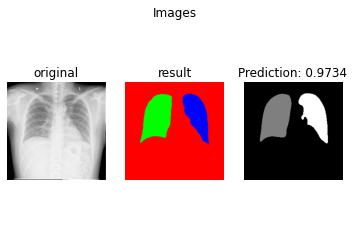

In [33]:
#######
i = random.randint(0,len(X_test)-1)

fig = plt.figure()
plt.title('Images')
plt.axis('off')

a = X_test[i]
b = y_test[i]
input = np.expand_dims(a,axis=0)
mask = np.expand_dims(b,axis=0)
preds_test = unet_model.predict(input)
preds_test_t = (np.argmax(preds_test, axis=-1)).reshape(256,256,1)
ret = unet_model.evaluate(input, mask)

# original
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(array_to_img(a),'gray')
ax1.set_title('original')
ax1.axis('off')

# result
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(b)
ax2.set_title('result')
ax2.axis('off')

# predict
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(array_to_img(preds_test_t),'gray')
ax3.set_title('Prediction: %.4f'%(ret[1]))
ax3.axis('off')

plt.show()

In [34]:
from skimage import io
save_img = (preds_test_t*0.5*255).astype('uint8')
io.imsave(f'./image{i}.png',save_img)

In [ ]:
path = f'./image{i}.png'

In [ ]:
# Filtering
import cv2
def image_filter(path):
  img = cv2.imread(path)
  plt.figure(figsize=(8,8))
  plt.subplot(2,3,1)
  plt.imshow(a)
  plt.title('Original')
  plt.axis('off')

  plt.subplot(2,3,2)
  plt.imshow(img)
  plt.title('Prediction: %.4f'%(ret[1]))
  plt.axis('off')
  
  # Average Filter
  img_avg = img.copy()
  k_size = 10 # size of kernel 
  average = cv2.blur(img_avg, (k_size,k_size))

  plt.subplot(2,3,3)
  plt.imshow(average)
  plt.title(f'{k_size}*{k_size} kernel Averaging')
  plt.axis('off')

  # Gaussian Filter
  img_gaussian = img.copy()
  img_gaussian = np.clip((img/255 + np.random.normal(scale = 0.1,size = img.shape)) * 255, 0, 255).astype('uint8')
  k_size = 9 # size of kernel 
  gaussian = cv2.GaussianBlur(img_gaussian, (k_size,k_size), 0)

  plt.subplot(2,3,4)
  plt.imshow(gaussian)
  plt.title(f'{k_size}*{k_size} kernel Gaussian')
  plt.axis('off')

  # Median Filter
  img_median = img.copy()
  np.random.seed(0)
  N = 10000
  idx1 = np.random.randint(img_median.shape[0],size = N)
  idx2 = np.random.randint(img_median.shape[1],size = N)
  img_median[idx1, idx2] = 0
  k_size = 15 # size of kernel 
  median = cv2.medianBlur(img_median, k_size)

  plt.subplot(2,3,5)
  plt.imshow(median)
  plt.title(f'{k_size}*{k_size} kernel Median')
  plt.axis('off')

  # Bilateral Filter
  img_bilateral = img.copy()
  img_bilateral = np.clip((img/255 + np.random.normal(scale = 0.1,size = img.shape)) * 255, 0, 255).astype('uint8')
  k_size = 15 # size of kernel 
  bilateral = cv2.medianBlur(img_bilateral, k_size, 75)

  plt.subplot(2,3,6)
  plt.imshow(bilateral)
  plt.title(f'{k_size}*{k_size} kernel Bilateral')
  plt.axis('off')

  plt.show()

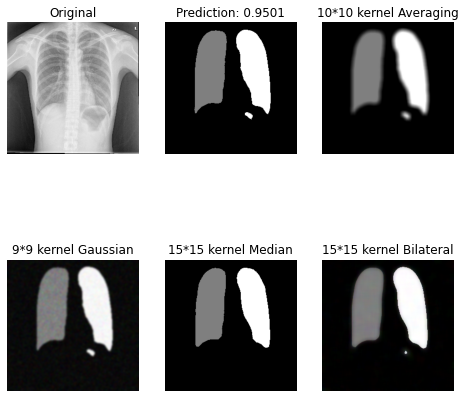

In [ ]:
image_filter(path)

## 노이즈 제거 

- 필요한 작업:
  - 노이즈 제거 알고리즘 
  - 노이즈 제거 후 원래 mask 값과 노이즈 제거 후 값을 비교하여 dice score 를 뽑아 내야 한다. 
  - 노이즈 제거 전, dice score 도 알아내야 한다. 

In [ ]:
###############
import tensorflow as tf
n = 15
a = X_test[n]
b = y_test[n]
input = np.expand_dims(a,axis=0)
mask = np.expand_dims(b,axis=0)
preds_test = unet_model.predict(input) # (1,256,256,3)

y_true = mask # (1,256,256,3)
y_pred = tf.cast(preds_test, tf.double) # double tensor -> 64bit
dice_coef(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.9727171774822306>

In [ ]:
unet_model.evaluate(input, mask)

1/1 [==============================] - 0s 61ms/step - loss: 0.0453 - dice_coef: 0.9727


[0.04528722167015076, 0.9727171659469604]

In [ ]:
# dice_coef(y_true, y_filter)
# input.shape => (1,256,256,3), 3: [0,1,2]label
# y_filter -> (1,256,256,3)

In [ ]:
preds_test_t = (np.argmax(preds_test, axis=-1)).reshape(256,256,1) # (256,256,1)


In [ ]:
#### 
def remove_noise(preds_test):
  preds_test_t = (np.argmax(preds_test, axis=-1)).reshape(256,256,1)


In [ ]:
y_pred

In [ ]:
preds_test_t = (np.argmax(preds_test, axis=-1)).reshape(256,256,1)

---

In [ ]:
import cv2
# 1. Averaging Filter
def average_filter(path):
  img = cv2.imread(path)
  img_avg = img.copy()

  k_size = 10 # size of kernel 
  average = cv2.blur(img_avg, (k_size,k_size))

  plt.subplot(1,2,1)
  plt.imshow(img_avg)
  plt.title('original')
  plt.axis('off')

  plt.subplot(1,2,2)
  plt.imshow(average)
  plt.title('10*10 kernel averaging')
  plt.axis('off')
  
  plt.show()
  

In [ ]:
# 2. Gaussian Filtering 
def gaussian_filter(path):
  img = cv2.imread(path)
  img_gaussian = img.copy()
  img_gaussian = np.clip((img/255 + np.random.normal(scale = 0.1,size = img.shape)) * 255, 0, 255).astype('uint8')
  
  k_size = 7 # size of kernel 
  gaussian = cv2.GaussianBlur(img_gaussian, (k_size,k_size), 0)

  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.title('Original')
  plt.axis('off')

  plt.subplot(1,2,2)
  plt.imshow(gaussian)
  plt.title('7*7 kernel Gaussian')
  plt.axis('off')
  
  plt.show()

In [ ]:
# 3. Median Filtering
def median_filter(path):
  img = cv2.imread(path)
  img_median = img.copy()

  np.random.seed(0)
  N = 10000
  idx1 = np.random.randint(img_median.shape[0],size = N)
  idx2 = np.random.randint(img_median.shape[1],size = N)
  img_median[idx1, idx2] = 0

  k_size = 11 # size of kernel 
  median = cv2.medianBlur(img_median, k_size)

  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.title('Original')
  plt.axis('off')

  plt.subplot(1,2,2)
  plt.imshow(median)
  plt.title('11*11 kernel Median')
  plt.axis('off')
  
  plt.show()

In [ ]:
# 4. Bilateral Filtering
def bilateral_filtering(path):
  img = cv2.imread(path)
  img_bilateral = img.copy()
  img_bilateral = np.clip((img/255 + np.random.normal(scale = 0.1,size = img.shape)) * 255, 0, 255).astype('uint8')
  
  k_size = 9 # size of kernel 
  bilateral = cv2.medianBlur(img_bilateral, k_size, 75)

  plt.subplot(1,2,1)
  plt.imshow(img)
  plt.title('Original')
  plt.axis('off')

  plt.subplot(1,2,2)
  plt.imshow(bilateral)
  plt.title('9*9 kernel Bilateral')
  plt.axis('off')
  
  plt.show()

In [ ]:
# # # Tensor Board와 연결하기
# log_dir = './graph'
# tb_hist = keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=0,write_graph=True, write_images=True)
# model.fit(X_train,y_train,epochs=1000,batch_size=10,validation_data=(X_val,y_val),callbacks=[tb_hist])

In [ ]:
# # TensorBoard 확인하기 
# %load_ext tensorboard 
# %tensorboard --logdir=log_dir --port=6006

In [ ]:
# # 모델 불러오기
# from keras.models import load_model
# model = load_model('Unet_model.h5')

# y_pred = model.predic(X_test)